# Part 1: Preliminaries

In [35]:
!pip install shap
!pip install torch
!pip install torchvision
!pip install matplotlib

In [36]:
import shap

display_images = shap.datasets.imagenet50()[0].astype('uint8')  # shape = (50, 224, 224, 3)

In [37]:
from torchvision import models

model = models.resnet18(pretrained=True)
model = model.eval()  # turns off training mode for batch norm

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
import torchvision.transforms as transforms

# Image pre-processing, expects single image of size (224, 224, 3)
model_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [39]:
import torch

# Apply pre-processing and make predictions
images = torch.stack([model_transforms(img) for img in display_images])
pred = model(images).softmax(dim=1)

# Part 2: Occlusion

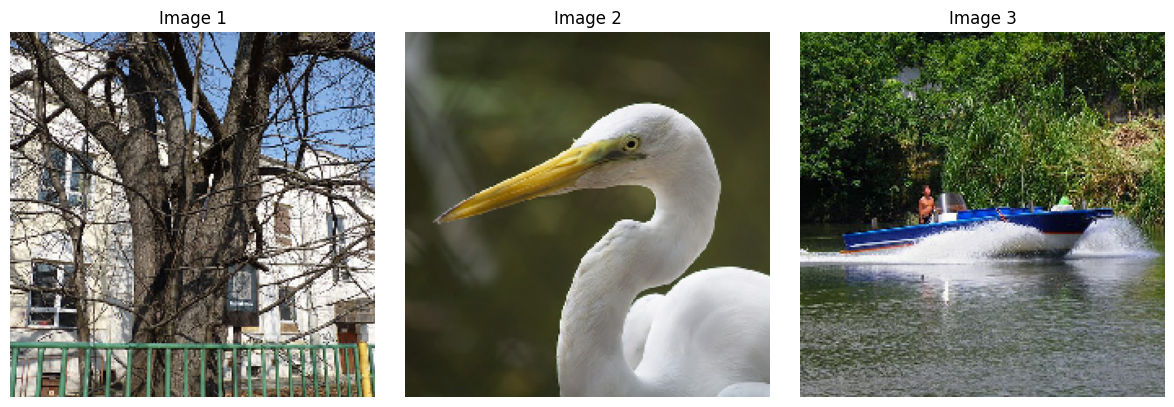

In [40]:
import matplotlib.pyplot as plt

# Plot the first three images before pre-processing
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as needed
for i, ax in enumerate(axes.flat):
    ax.imshow(display_images[i])
    ax.set_title(f"Image {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [41]:
# Predict classes for the first three images
with torch.no_grad():  # Disable gradient calculation for inference
    pred = model(images[:3]).softmax(dim=1)  # Predict for the first 3 images
    predicted_classes = torch.argmax(pred, dim=1)  # Get the class with the highest probability

# Print the predicted class indices
print("Predicted class indices:", predicted_classes.tolist())

Predicted class indices: [829, 132, 814]


In [42]:
import numpy as np
import torch.nn.functional as F


def occlusion(imgs, model, target_labels, baseline, superpixel_size=8):
    '''
    Args:
      imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224)
      model: PyTorch classifier
      target_labels: torch.Tensor of classes for each image, size = (batch,)
      baseline: baseline value for occluded features
      superpixel_size: width/height of superpixels

    Returns:
      importance: occlusion scores, size = (batch, 224, 224)
    '''
    batch_size, _, height, width = imgs.shape  # Get image dimensions

    # Initialize importance scores tensor
    importance = torch.zeros(batch_size, height, width, device=imgs.device)

    # Loop over each superpixel in the image grid
    for i in range(0, height, superpixel_size):
        for j in range(0, width, superpixel_size):
            # Create a mask for the current superpixel
            mask = torch.ones_like(imgs)
            mask[:, :, i:i + superpixel_size, j:j + superpixel_size] = 0

            # Apply the mask and replace the masked region with the baseline
            masked_imgs = imgs * mask + (1 - mask) * baseline.unsqueeze(0)

            # Predict with masked images
            with torch.no_grad():
                logits = model(masked_imgs)
                probs = F.softmax(logits, dim=1)

            # Calculate the probability of the target class for each masked image
            target_probs = probs[torch.arange(batch_size), target_labels]

            # Get the importance score for the current superpixel
            importance[:, i:i + superpixel_size, j:j + superpixel_size] = (
                probs[torch.arange(batch_size), target_labels].unsqueeze(-1).unsqueeze(-1)
            )

    return importance

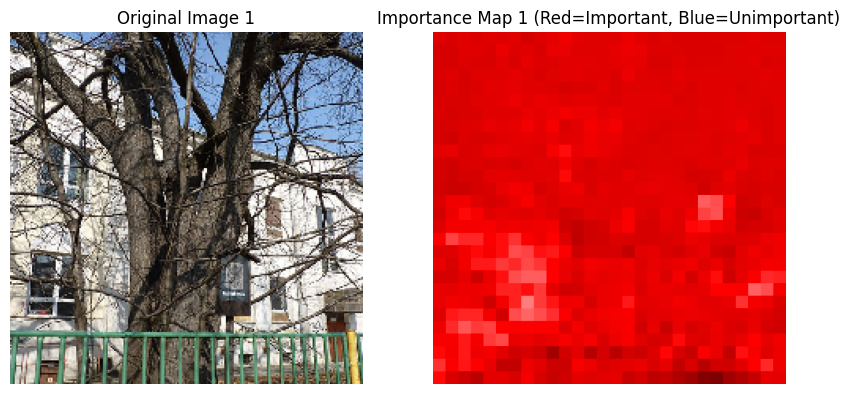

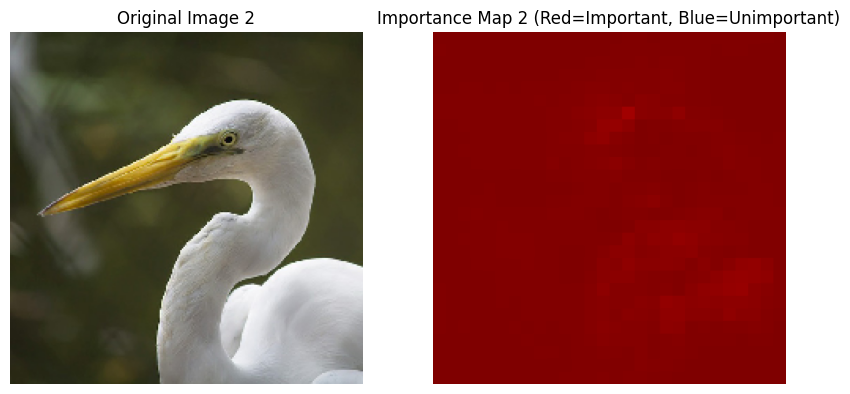

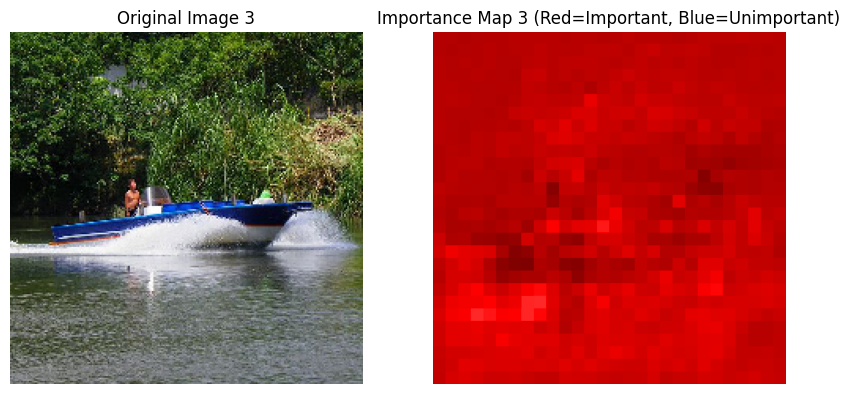

In [43]:
baseline = model_transforms(np.zeros((224, 224, 3), np.uint8))

# Calculate importance scores for the first three images
importance_scores = occlusion(images[:3], model, predicted_classes, baseline, superpixel_size=8)

# Visualize importance for each image
for i in range(3):  # Visualize the first three images
    single_importance = importance_scores[i]  # Importance map for a single image

    # Find the maximum absolute value for symmetric colormap scaling
    m = single_importance.abs().max()

    plt.figure(figsize=(10, 5))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(display_images[i])
    plt.title(f"Original Image {i + 1}")
    plt.axis('off')  # Hide axis labels and ticks

    # Display the importance heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(single_importance, vmin=-m, vmax=m, cmap='seismic')
    plt.title(f"Importance Map {i + 1} (Red=Important, Blue=Unimportant)")
    plt.axis('off')

    plt.show()

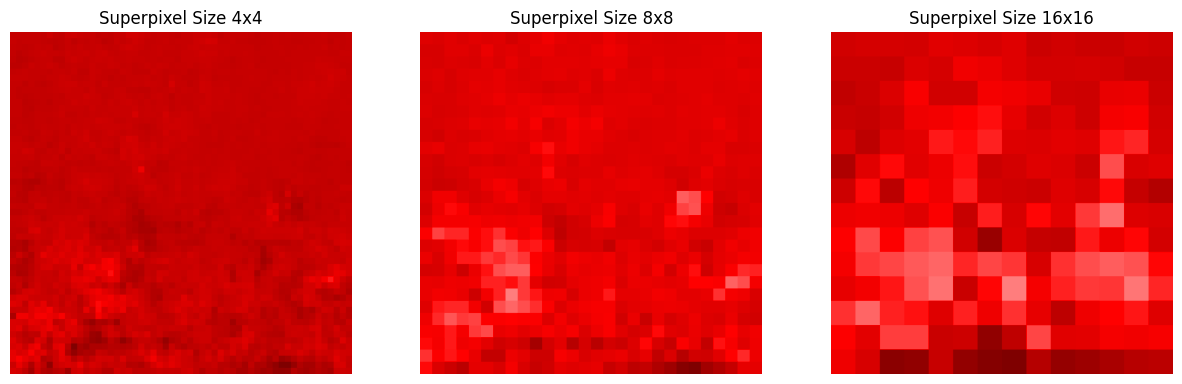

In [44]:
import matplotlib.pyplot as plt

superpixel_sizes = [4, 8, 16]  # Different sizes to test

plt.figure(figsize=(15, 5))

# Calculate and visualize for each superpixel size
for i, size in enumerate(superpixel_sizes):
    importance = occlusion(
        images[:1],  # Use only the first image
        model,
        predicted_classes[:1],
        baseline,
        superpixel_size=size
    )[0]  # Extract importance for the first image

    m = importance.abs().max()

    plt.subplot(1, 3, i + 1)  # 3 subplots for the different sizes
    plt.imshow(importance, vmin=-m, vmax=m, cmap='seismic')
    plt.title(f"Superpixel Size {size}x{size}")
    plt.axis('off')

plt.show()


<ipython-input-45-d5f2aec86acc>:14: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  blurred_img = gaussian(display_images[j], sigma=sigma, multichannel=True)


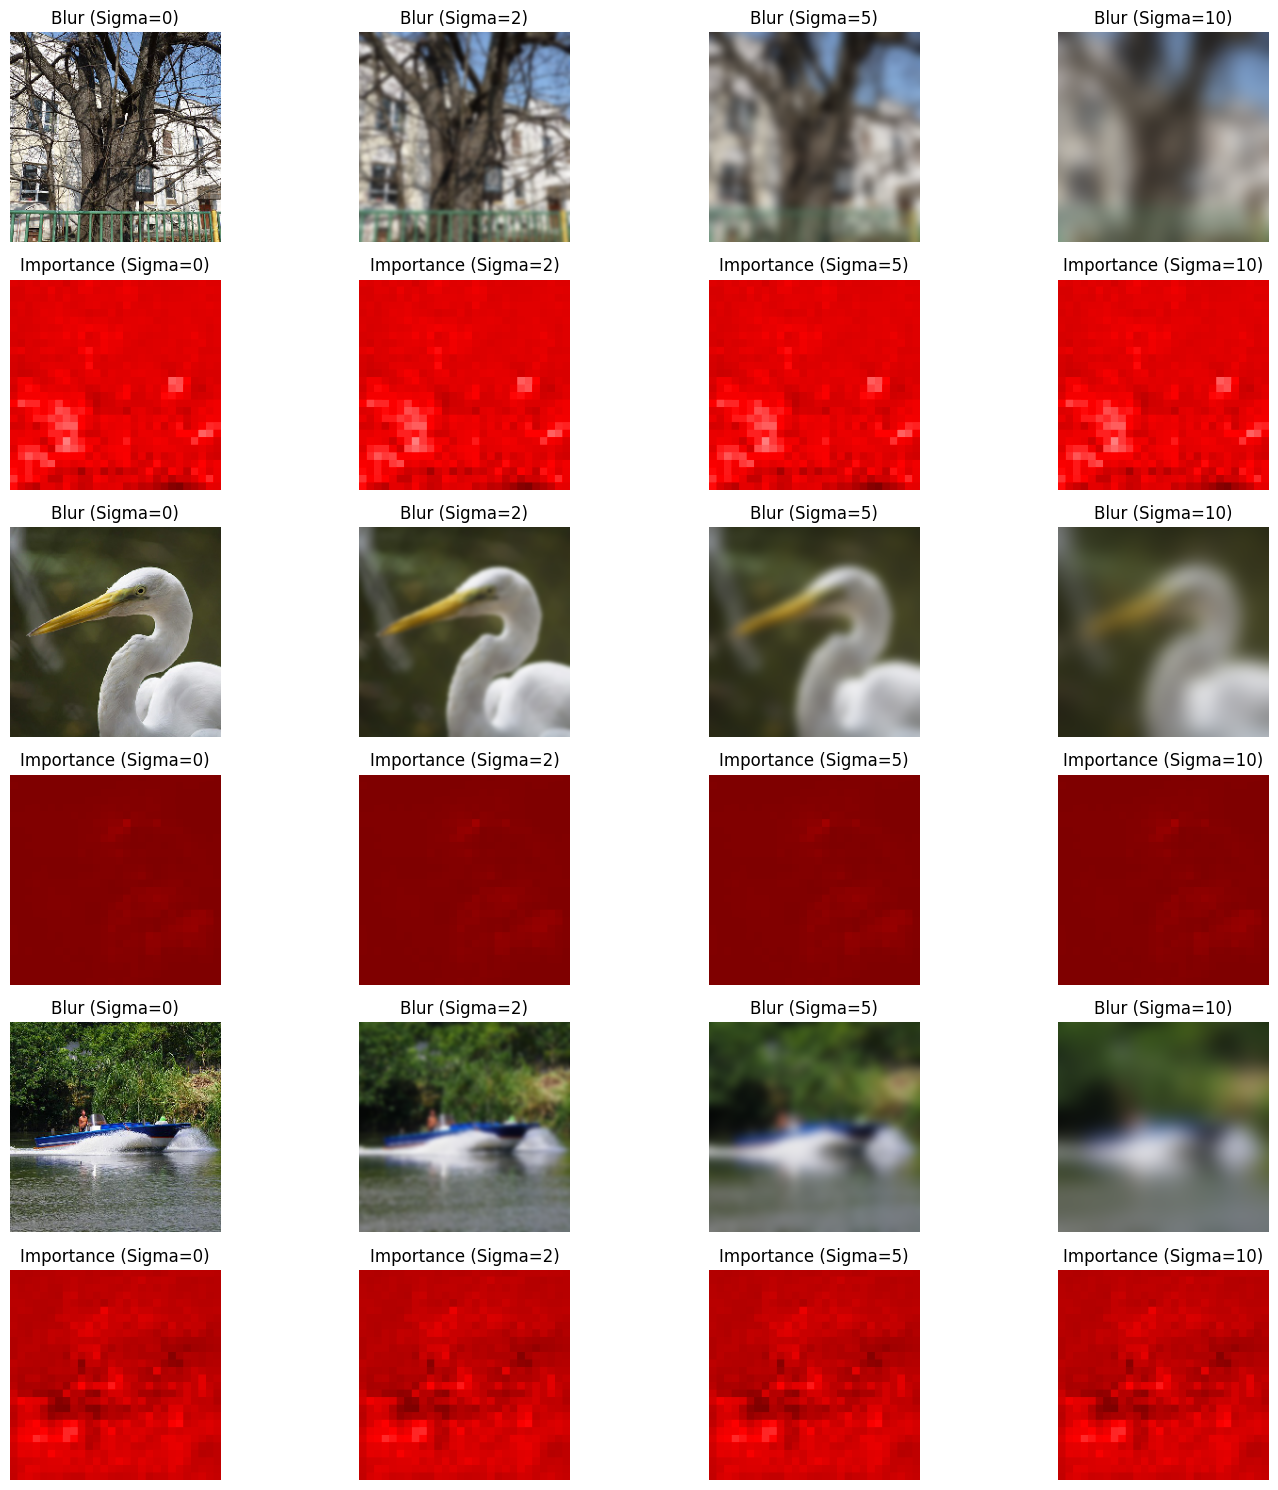

In [45]:
import matplotlib.pyplot as plt
from skimage.filters import gaussian

# Blurring Strengths:
sigmas = [0, 2, 5, 10]

num_images = 3  # Use the first 3 images
num_blur_levels = len(sigmas)
fig, axs = plt.subplots(num_images * 2, num_blur_levels, figsize=(15, 5 * num_images))

for j in range(num_images):
    for i, sigma in enumerate(sigmas):
        # Create blurred baseline
        blurred_img = gaussian(display_images[j], sigma=sigma, multichannel=True)
        blurred_baseline = model_transforms(blurred_img.astype(np.uint8)).to(images.device)

        # Calculate importance for each image
        importance = occlusion(
            images[j:j+1],  # Take a slice of the image tensor
            model,
            predicted_classes[j:j+1],  # Corresponding prediction
            blurred_baseline,
            superpixel_size=8
        )[0]  # Get importance for this image

        m = importance.abs().max()

        # Plotting
        axs[j * 2, i].imshow(blurred_img)
        axs[j * 2, i].set_title(f"Blur (Sigma={sigma})")
        axs[j * 2, i].axis('off')

        axs[j * 2 + 1, i].imshow(importance, vmin=-m, vmax=m, cmap='seismic')
        axs[j * 2 + 1, i].set_title(f"Importance (Sigma={sigma})")
        axs[j * 2 + 1, i].axis('off')

plt.tight_layout()  # Adjust spacing
plt.show()


# Part 3: Gradient-based explanations

In [46]:
def calculate_gradients(imgs, model, target_labels):
    '''
    Args:
      imgs: torch.Tensor of pre-processed images, size = (batch, 3, 224, 224)
      model: PyTorch classifier
      target_labels: torch.Tensor of classes for each image, size = (batch,)

    Returns:
      gradients: gradients for the target class, shape = (batch, 3, 224, 224)
    '''
    # Prepare for model.
    imgs = imgs.clone()
    imgs.requires_grad = True

    # Make prediction.
    output = model(imgs).softmax(dim=1)

    # Sum outputs for target classes.
    mask = torch.zeros(output.shape)
    for i, target in enumerate(target_labels):
        mask[i, target] = 1
    backprop_output = torch.sum(output * mask)

    # Calculate gradients.
    model.zero_grad()
    backprop_output.backward()

    # Convert gradients to numpy.
    gradients = imgs.grad.detach()
    return gradients

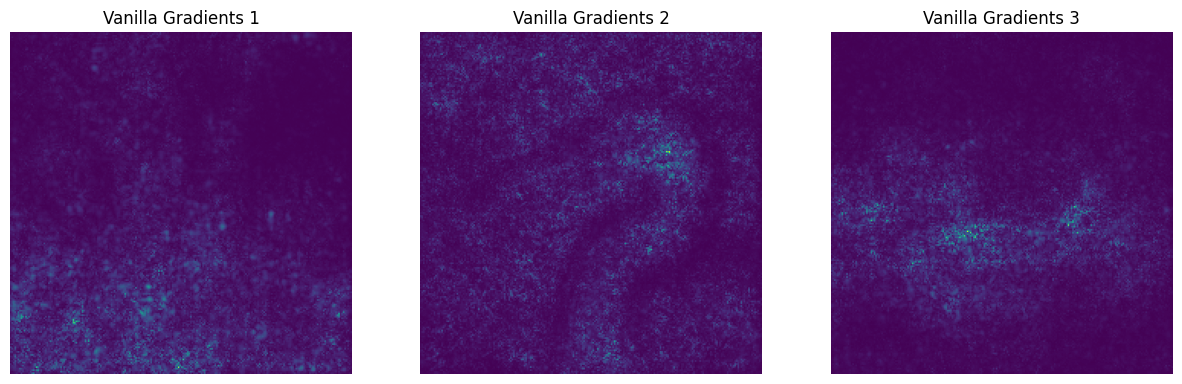

In [47]:
import matplotlib.pyplot as plt

def vanilla_gradients(imgs, model, target_labels):
    # Calculate gradients
    gradients = calculate_gradients(imgs, model, target_labels)

    # Absolute value and sum across channels
    saliency = torch.sum(torch.abs(gradients), dim=1)  # Sum across channels (dim=1)

    return saliency

# Calculate vanilla gradients
vanilla_saliency_maps = vanilla_gradients(images[:3], model, predicted_classes)

# Plotting
plt.figure(figsize=(15, 5))
for i in range(3):
    vanilla = vanilla_saliency_maps[i].cpu().numpy()

    plt.subplot(1, 3, i + 1)
    plt.imshow(display_images[i])
    plt.imshow(vanilla, vmin=0, vmax=vanilla.max())
    plt.title(f"Vanilla Gradients {i + 1}")
    plt.axis('off')

plt.show()


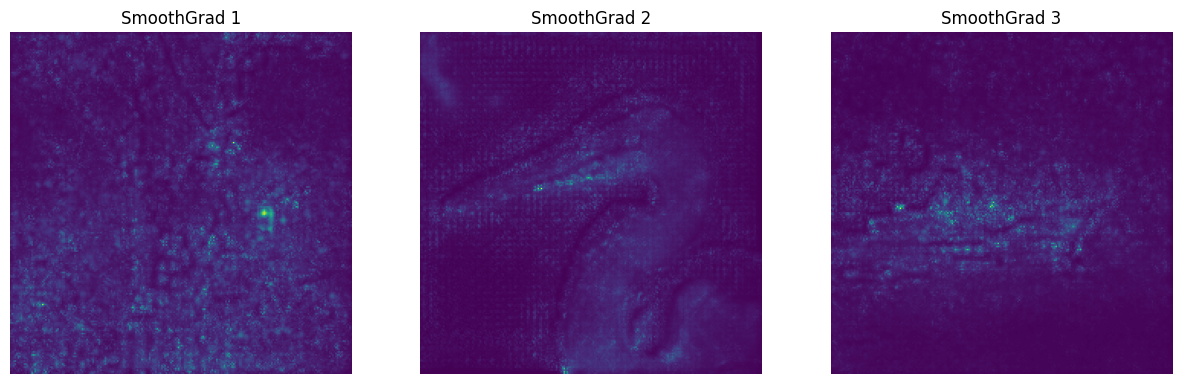

In [48]:
def smoothgrad(imgs, model, target_labels, samples=50, sigma=0.1):
    batch_size = imgs.size(0)  # Get batch size

    # Prepare noise
    noise = torch.randn((batch_size, samples, 3, 224, 224), device=imgs.device) * sigma

    saliency_maps = []
    for sample_idx in range(samples):
        # Add noise
        noisy_imgs = imgs + noise[:, sample_idx, :, :, :]
        noisy_imgs = noisy_imgs.clamp(0, 1)  # Clip to [0, 1]

        # Calculate gradients
        gradients = calculate_gradients(noisy_imgs, model, target_labels)

        # Sum across channels
        saliency = gradients.abs().sum(dim=1)

        saliency_maps.append(saliency)

    # Average and return
    averaged_saliency = torch.stack(saliency_maps).mean(dim=0)
    return averaged_saliency


# Calculate SmoothGrad saliency maps
smoothgrad_saliency_maps = smoothgrad(images[:3], model, predicted_classes)

# Plotting
plt.figure(figsize=(15, 5))
for i in range(3):
    smoothgrad_map = smoothgrad_saliency_maps[i].cpu().numpy()

    plt.subplot(1, 3, i + 1)
    plt.imshow(display_images[i])
    plt.imshow(smoothgrad_map, vmin=0, vmax=smoothgrad_map.max())
    plt.title(f"SmoothGrad {i + 1}")
    plt.axis('off')

plt.show()


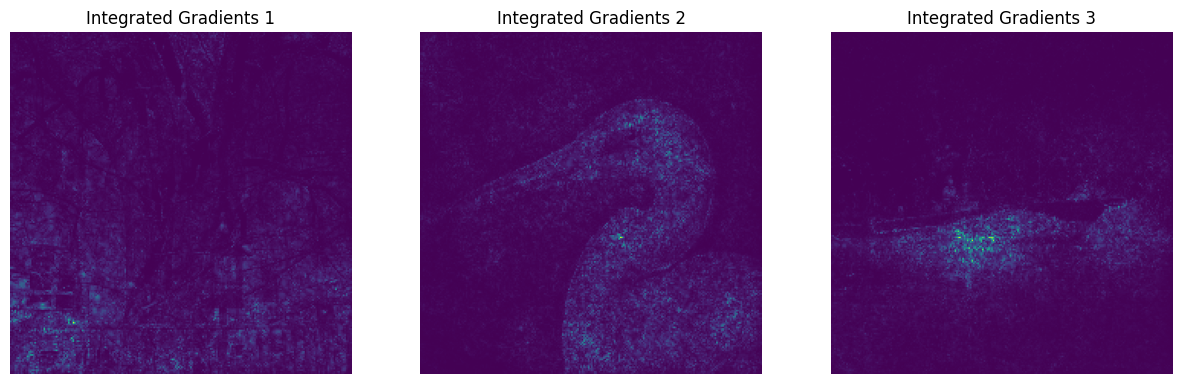

In [49]:
def integrated_gradients(imgs, model, target_labels, baseline, steps=50):
    batch_size, channels, _, _ = imgs.shape

    # Generate alphas for linear interpolation
    alphas = torch.linspace(0, 1, steps=steps + 1, device=imgs.device)

    # Create a tensor to hold the gradients
    scaled_grads = torch.zeros((batch_size, channels, imgs.shape[2], imgs.shape[3]), device=imgs.device)

    # Iterate over each alpha value
    for alpha in alphas:
        # Generate interpolated images
        interpolated_images = baseline + alpha * (imgs - baseline)

        # Calculate gradients for this alpha value
        interpolated_images.requires_grad_(True)
        output = model(interpolated_images)

        # Create a one-hot mask for the target class
        mask = F.one_hot(target_labels, num_classes=output.size(1)).to(imgs.device)

        # Backpropagate through the model to get gradients
        model.zero_grad()
        output.backward(gradient=mask, retain_graph=True)  # Use the mask in backward

        # Accumulate the scaled gradients
        scaled_grads += interpolated_images.grad * (imgs - baseline)

    # Average the gradients and return saliency map
    avg_grads = scaled_grads / (steps + 1)
    saliency = avg_grads.abs().sum(dim=1)

    return saliency

baseline = model_transforms(np.zeros((224, 224, 3), np.uint8))
ig_saliency_maps = integrated_gradients(images[:3], model, predicted_classes, baseline)

# Plotting
plt.figure(figsize=(15, 5))
for i in range(3):
    ig_map = ig_saliency_maps[i].cpu().numpy()

    plt.subplot(1, 3, i + 1)
    plt.imshow(display_images[i])
    plt.imshow(ig_map, vmin=0, vmax=ig_map.max())
    plt.title(f"Integrated Gradients {i + 1}")
    plt.axis('off')

plt.show()


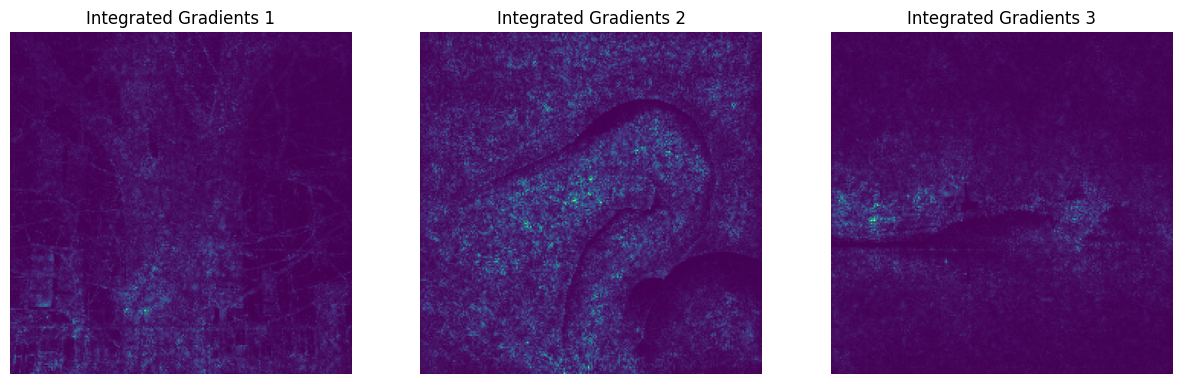

In [50]:
# Generate white image, then apply pre-processing
baseline = model_transforms(255 * np.ones((224, 224, 3), np.uint8))

ig_saliency_maps = integrated_gradients(images[:3], model, predicted_classes, baseline)

# Plotting
plt.figure(figsize=(15, 5))
for i in range(3):
    ig_map = ig_saliency_maps[i].cpu().numpy()

    plt.subplot(1, 3, i + 1)
    plt.imshow(display_images[i])
    plt.imshow(ig_map, vmin=0, vmax=ig_map.max())
    plt.title(f"Integrated Gradients {i + 1}")
    plt.axis('off')

plt.show()

# Part 4: Ablation metrics

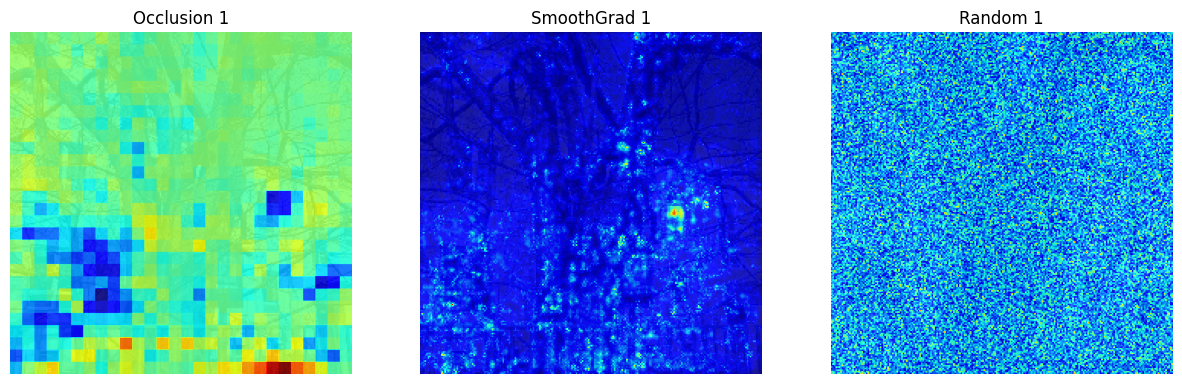

In [51]:
# Reset baseline
baseline = model_transforms(np.zeros((224, 224, 3), np.uint8))
num_images = 10
display_images = shap.datasets.imagenet50()[0][:num_images].astype('uint8')
images = torch.stack([model_transforms(img) for img in display_images])

with torch.no_grad():
    pred = model(images).softmax(dim=1)
    predicted_classes = torch.argmax(pred, dim=1)

# Generate feature importance using Occlusion
occlusion_saliency_maps = occlusion(images, model, predicted_classes, baseline, superpixel_size=8)

# Generate feature importance using SmoothGrad
smoothgrad_saliency_maps = smoothgrad(images, model, predicted_classes, samples=50, sigma=0.15)

# Generate random baseline saliency maps
random_saliency_maps = torch.randn_like(images).abs().sum(dim=1)

# Plotting saliency maps for one image (first image in this case)
image_index = 0
plt.figure(figsize=(15, 5))

methods = [occlusion_saliency_maps, smoothgrad_saliency_maps, random_saliency_maps]
method_names = ["Occlusion", "SmoothGrad", "Random"]

for i, (saliency_map, method_name) in enumerate(zip(methods, method_names)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(display_images[image_index])

    normalized_saliency_map = saliency_map[image_index].cpu().numpy()
    normalized_saliency_map = (normalized_saliency_map - normalized_saliency_map.min()) / (normalized_saliency_map.max() - normalized_saliency_map.min())

    # Apply a colormap for better visualization
    plt.imshow(normalized_saliency_map, alpha=0.90, cmap='jet')
    plt.title(f"{method_name} {image_index + 1}")
    plt.axis('off')

plt.show()


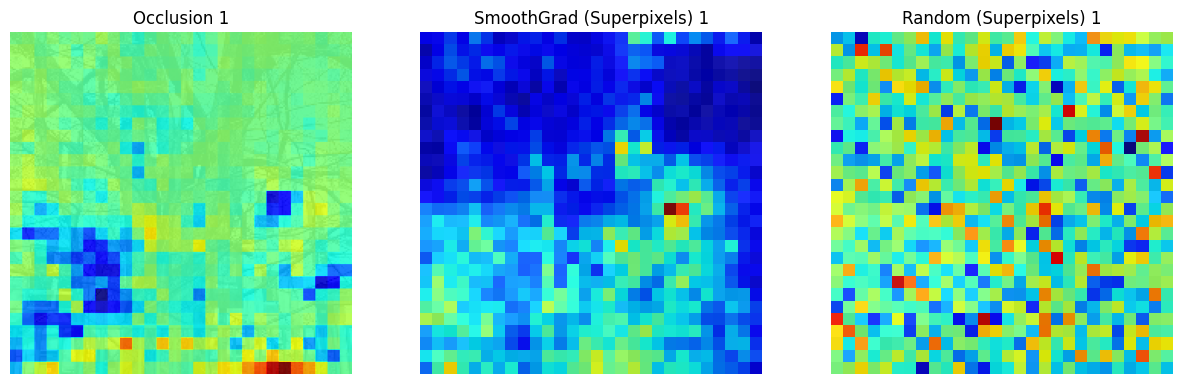

In [52]:
import torch.nn as nn

# Reduce granularity to 8x8 superpixels using AvgPool2d
superpixel_size = 8
avg_pool = nn.AvgPool2d(kernel_size=superpixel_size, stride=superpixel_size)

# SmoothGrad superpixel reduction
smoothgrad_superpixels = avg_pool(smoothgrad_saliency_maps)

# Random superpixel reduction
random_superpixels = avg_pool(random_saliency_maps)

# Plotting new superpixel saliency maps for the same image
plt.figure(figsize=(15, 5))
methods = [occlusion_saliency_maps, smoothgrad_superpixels, random_superpixels]
method_names = ["Occlusion", "SmoothGrad (Superpixels)", "Random (Superpixels)"]

for i, (saliency_map, method_name) in enumerate(zip(methods, method_names)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(display_images[image_index])

    normalized_saliency_map = saliency_map[image_index].cpu().numpy()
    normalized_saliency_map = (normalized_saliency_map - normalized_saliency_map.min()) / (normalized_saliency_map.max() - normalized_saliency_map.min())

    # Apply a colormap for better visualization
    plt.imshow(normalized_saliency_map, alpha=0.9, cmap='jet')
    plt.title(f"{method_name} {image_index + 1}")
    plt.axis('off')

plt.show()


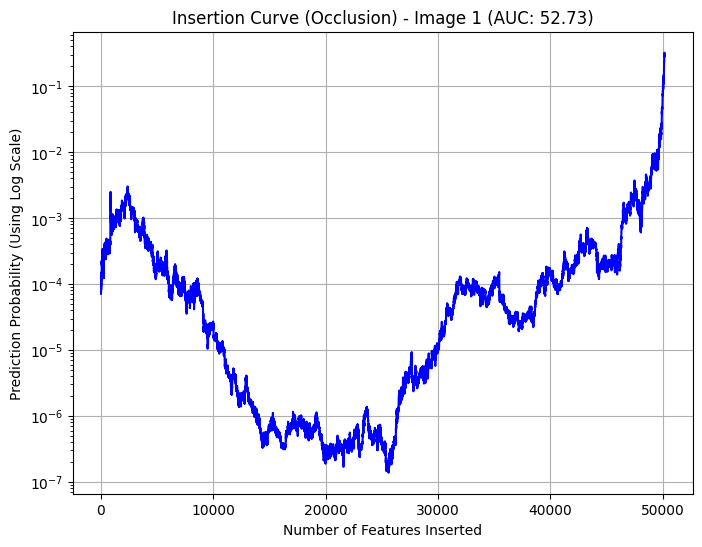

In [53]:
from scipy.integrate import trapezoid

def insertion(img, model, importance, target_label, baseline):
    '''
    Args:
        img: image to ablate, size = (1, 3, 224, 224)
        model: PyTorch classifier
        importance: feature importance values, size = (1, 28, 28)
        target_label: index of target class
        baseline: baseline value for held-out features

    Returns:
        curve: array of prediction probabilities after each step
        num_feats: array of number of features after each step
    '''
    # Flatten the importance map and get indices sorted in descending order
    importance_flat = importance.view(-1)
    sorted_indices = torch.argsort(importance_flat, descending=True)

    # Initialize arrays to store probabilities and feature counts
    curve = []
    num_feats = []

    # Create a mask for inserting features
    mask = torch.zeros_like(importance)

    for i in range(len(sorted_indices)):
        # Insert the next most important feature
        idx = sorted_indices[i]
        mask.view(-1)[idx] = 1

        # Create the masked image by replacing masked regions with baseline
        masked_img = img * mask + (1 - mask) * baseline

        # Predict the masked image
        with torch.no_grad():
            logits = model(masked_img)
            probs = F.softmax(logits, dim=1)

        # Store the probability of the target class and number of features inserted
        curve.append(probs[0, target_label].item())
        num_feats.append(mask.sum().item())

    return curve, num_feats

# Plot the curve for Occlusion for a single image
image_index = 0
img = images[image_index].unsqueeze(0)
importance = occlusion_saliency_maps[image_index].unsqueeze(0)
target_label = predicted_classes[image_index].item()

curve, num_feats = insertion(img, model, importance, target_label, baseline)

# Calculate area under the curve using trapezoidal rule
area = trapezoid(curve, num_feats)

plt.figure(figsize=(8, 6))
plt.plot(num_feats, curve, linestyle='-', color='blue')
plt.yscale('log')
plt.title(f"Insertion Curve (Occlusion) - Image {image_index + 1} (AUC: {area:.2f})")
plt.xlabel("Number of Features Inserted")
plt.ylabel("Prediction Probability (Using Log Scale)")
plt.grid(True)
plt.show()


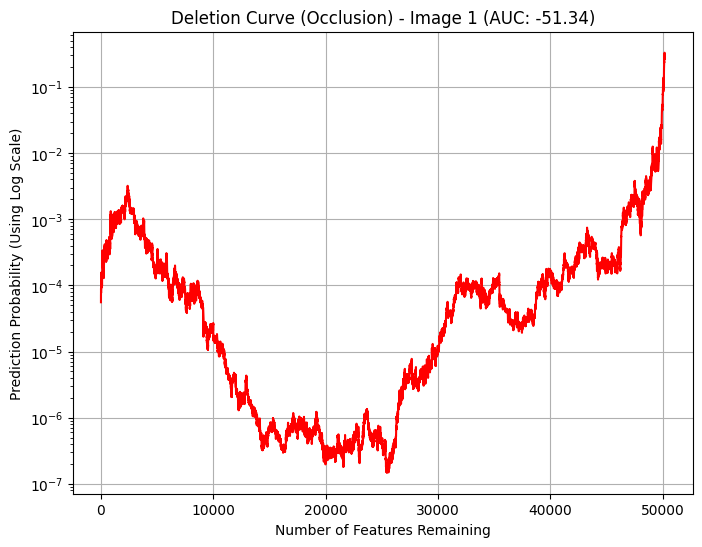

In [54]:
def deletion(img, model, importance, target_label, baseline):
    '''
    Args:
        img: image to ablate, size = (1, 3, 224, 224)
        model: PyTorch classifier
        importance: feature importance values, size = (1, 28, 28)
        target_label: index of target class
        baseline: baseline value for held-out features

    Returns:
        curve: array of prediction probabilities after each step
        num_feats: array of number of features after each step
    '''
    # Flatten the importance map and get indices sorted in ascending order
    importance_flat = importance.view(-1)
    sorted_indices = torch.argsort(importance_flat)

    # Initialize arrays to store probabilities and feature counts
    curve = []
    num_feats = []

    # Create a mask for deleting features
    mask = torch.ones_like(importance)

    for i in range(len(sorted_indices)):
        # Delete the next least important feature
        idx = sorted_indices[i]
        mask.view(-1)[idx] = 0

        # Create the masked image by replacing masked regions with baseline
        masked_img = img * mask + (1 - mask) * baseline

        # Predict the masked image
        with torch.no_grad():
            logits = model(masked_img)
            probs = F.softmax(logits, dim=1)

        # Store the probability of the target class and number of features remaining
        curve.append(probs[0, target_label].item())
        num_feats.append(mask.sum().item())

    return curve, num_feats

# Plot the curve for Occlusion for a single image
image_index = 0
img = images[image_index].unsqueeze(0)
importance = occlusion_saliency_maps[image_index].unsqueeze(0)
target_label = predicted_classes[image_index].item()

curve, num_feats = deletion(img, model, importance, target_label, baseline)

# Calculate area under the curve using trapezoidal rule
area = trapezoid(curve, num_feats)

plt.figure(figsize=(8, 6))
plt.plot(num_feats, curve, linestyle='-', color='red')
plt.yscale('log')
plt.title(f"Deletion Curve (Occlusion) - Image {image_index + 1} (AUC: {area:.2f})")
plt.xlabel("Number of Features Remaining")
plt.ylabel("Prediction Probability (Using Log Scale)")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Prepare data for curves
num_images = 10
explanations = [
    occlusion_saliency_maps[:num_images],
    smoothgrad_superpixels[:num_images],
    random_superpixels[:num_images]
]

explanation_names = ["Occlusion", "SmoothGrad (Superpixels)", "Random (Superpixels)"]
target_labels = predicted_classes[:num_images]

# Generate insertion curves for each explanation and image
all_curves = []
for explanation in explanations:
    curves = []
    for i in range(num_images):
        curve, num_feats = insertion(
            images[i].unsqueeze(0), model, explanation[i].unsqueeze(0), target_labels[i].item(), baseline
        )
        curves.append(curve)
    all_curves.append(curves)

# Calculate average curves and AUCs
average_curves = []
average_aucs = []
for curves in all_curves:
    # Pad curves to the maximum length
    max_len = max(len(curve) for curve in curves)
    padded_curves = [curve + [curve[-1]] * (max_len - len(curve)) for curve in curves]

    # Calculate average curve
    average_curve = np.mean(padded_curves, axis=0)
    average_curves.append(average_curve)

    # Calculate average AUC
    aucs = [trapezoid(curve, np.arange(len(curve))) for curve in curves]
    average_auc = np.mean(aucs)
    average_aucs.append(average_auc)

# Plot average curves
plt.figure(figsize=(10, 6))
for average_curve, explanation_name in zip(average_curves, explanation_names):
    plt.plot(np.arange(len(average_curve)), average_curve, label=f"{explanation_name} (AUC: {average_aucs[explanation_names.index(explanation_name)]:.2f})")
plt.title("Average Insertion Curves")
plt.xlabel("Number of Features Inserted")
plt.ylabel("Average Prediction Probability")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Prepare data for curves
num_images = 10
explanations = [
    occlusion_saliency_maps[:num_images],
    smoothgrad_superpixels[:num_images],
    random_superpixels[:num_images]
]

explanation_names = ["Occlusion", "SmoothGrad (Superpixels)", "Random (Superpixels)"]
target_labels = predicted_classes[:num_images]

# Generate deletion curves for each explanation and image
all_curves = []
for explanation in explanations:
    curves = []
    for i in range(num_images):
        curve, num_feats = deletion(
            images[i].unsqueeze(0), model, explanation[i].unsqueeze(0), target_labels[i].item(), baseline
        )
        curves.append(curve)
    all_curves.append(curves)

# Calculate average curves and AUCs
average_curves = []
average_aucs = []
for curves in all_curves:
    # Pad curves to the maximum length
    max_len = max(len(curve) for curve in curves)
    padded_curves = [curve + [curve[-1]] * (max_len - len(curve)) for curve in curves]

    # Calculate average curve
    average_curve = np.mean(padded_curves, axis=0)
    average_curves.append(average_curve)

    # Calculate average AUC
    aucs = [trapezoid(curve, np.arange(len(curve))) for curve in curves]
    average_auc = np.mean(aucs)
    average_aucs.append(average_auc)

# Plot average curves
plt.figure(figsize=(10, 6))
for average_curve, explanation_name in zip(average_curves, explanation_names):
    plt.plot(np.arange(len(average_curve)), average_curve, label=f"{explanation_name} (AUC: {average_aucs[explanation_names.index(explanation_name)]:.2f})")
plt.title("Average Deletion Curves")
plt.xlabel("Number of Features Remaining")
plt.ylabel("Average Prediction Probability")
plt.legend()
plt.grid(True)
plt.show()
